In [1]:
!pip install transformers==2.11.0
!pip install tensorflow==2.2.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import os
import re
import json
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')

from tqdm import tqdm
import tensorflow as tf
from transformers import *
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [3]:
tf.random.set_seed(42)
np.random.seed(42)

BATCH_SIZE = 32
NUM_EPOCHS = 3
VALID_SPLIT = 0.2
MAX_LEN = 100

In [4]:
from google.colab import files
filename = files.upload()

Saving train.csv to train (1).csv


In [5]:
import pandas as pd
df = pd.read_csv('train.csv', index_col=0)
df.head()

,text,label
0,일단 잘 알겠고요 저희들이 kb금융 계열사 kb저축은행인데요. 지금 5월 달에 저희...,1
1,네 고객님 네네 하합니다. 네 근데 제가 전화해 보니까 네네 없으시다고 하던데요. ...,1
2,일단 잘 알겠고요 저희들이 kb금융 계열사 kb저축은행인데요. 지금 5월 달에 저희...,1
3,네 고객님 네네 하합니다. 네 근데 제가 전화해 보니까 네네 없으시다고 하던데요. ...,1
4,예 저 어떻게 피자 네 예 심사 결과 확인돼서 연락드렸고 어떻게 통화 괜찮으신가요 ...,1


In [6]:
df = df.drop_duplicates()

In [7]:
df.isnull().sum()

text     1
label    0
dtype: int64

In [8]:
df = df.dropna()

In [9]:
df.reset_index(drop=True, inplace=True)

In [10]:
df['label'].value_counts()

0    726
1    183
Name: label, dtype: int64

In [11]:
df1 = df.sample(frac=1).reset_index(drop=True) # 간단셔플

In [12]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df1, test_size=0.2, shuffle=True)

In [13]:
print(train.shape, test.shape)

(727, 2) (182, 2)


In [14]:
train.head(20)

,text,label
507,"OO은행은행입니다. 무엇을 도와드릴까요? 텔레뱅킹, 스마트뱅킹으로 이체한 영수증을...",0
73,네 고객님 타행 인증서를 등록하셔서 인터넷뱅킹과 스마트뱅킹에서 사용이 가능하십니다...,0
206,계약자 본인명의의 계좌로 변경하시는 건가요? 홈페이지 접속 후 공인인증서를 통...,0
69,네 고객님 어떤 수술을 하셨나요? 일단 가입하신 보험 확인해드리겠습니다. 네 ...,0
162,자기차량 손해에 가입되어 있으면 보장받을 수 있습니다. 운전중 본인의 부주의나 ...,0
526,인적사항 알려주실수있으신가요? 드시는약이나 5년내 치료력이있으신가요? 직업이있...,0
577,"네, 고객님. 서명을 하셔서 보내시면 됩니다. 네, 수익자 본인 청구를 확인해...",0
218,펫보험입니다 고양이 종류와 생년월일 이름 그리고 등록번호알려주셔야 됩니다 동물...,0
555,감독원 오늘 전산보안팀입니다. 네 어디시라고요 금융감독원 은행 전산 보안팀입니다. ...,1
794,예 고객님 저 담당자입니다. 조금 전에 계속 이제 통화 중이고 해가지고 제가 도와주...,1


In [24]:
# pre-trained BERT tokenizer (다국어version / https://huggingface.co/bert-base-multilingual-cased)
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased', cache_dir='bert_ckpt', do_lower_case=False)

In [25]:
# 문장을 encode된 토큰과 attention mask를 반환하도록 함 
def bert_tokenizer(sentence, MAX_LEN):
  tokenized_text = tokenizer.encode_plus(text = sentence,
                                         add_special_tokens = True,
                                         max_length=MAX_LEN,
                                         pad_to_max_length = True,
                                         return_attention_mask = True
                                         )
  input_id = tokenized_text['input_ids']
  attention_mask = tokenized_text['attention_mask']
  token_type_id = tokenized_text['token_type_ids']
  return input_id, attention_mask, token_type_id

In [26]:
input_ids = []
attention_masks = []
token_type_ids = []
train_data_labels = []

for train_sentence, train_label in tqdm(zip(train['text'], train['label']), total = len(train)):
  try:
    input_id, attention_mask, token_type_id = bert_tokenizer(train_sentence, MAX_LEN)
    input_ids.append(input_id)
    attention_masks.append(attention_mask)
    token_type_ids.append(token_type_id)
    train_data_labels.append(train_label)
  except Exception as e:
    print(e)
    pass

100%|██████████| 727/727 [00:02<00:00, 336.48it/s]


In [27]:
train_input_ids = np.array(input_ids, dtype=int)
train_attention_masks = np.array(attention_masks, dtype=int)
train_token_type_ids = np.array(token_type_ids, dtype=int)
train_inputs = (train_input_ids, train_attention_masks, train_token_type_ids)
train_data_labels = np.asarray(train_data_labels, dtype=np.int32)

In [28]:
print('sentences: {}\nLabels: {}'.format(len(train_input_ids), len(train_data_labels)))

sentences: 727
Labels: 727


In [29]:
# tokenizer decode 확인
idx = 5

input_id = train_input_ids[idx]
attention_mask = train_attention_masks[idx]
token_type_id = train_token_type_ids[idx]

print(input_id, attention_mask, token_type_id)
print(tokenizer.decode(input_id))

[   101   9640  14801  12945  50632   9524  26737  16323  31503  15891
 119192 119185  25387  11287  48549    136   9113  14040  11018  47289
  43739    126  10954  31605   9779  38688  61964 119192 119185  25387
  11287  48549    136   9707  26784  10739 119192 119185  25387  11287
  48549    136  12314  24982  10739  14871  10892   9328  25934 118625
  18623  14423  83902 119085  48345   8845  20309  12945  42337  25934
  70146   9282  69023   8868  32159    100   9011    122  16323  18392
  16605  12092   9645  48345   9011    152  11403  14279  58303  48345
    100   9429  16758  15001  12692 118632 119081  48345    102      0
      0      0      0      0      0      0      0      0      0      0] [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0] [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0

In [30]:
class TFBertClassifier(tf.keras.Model):
  def __init__(self, model_name, dir_path, num_class):
    super(TFBertClassifier, self).__init__()
    self.bert = TFBertModel.from_pretrained(model_name, cache_dir=dir_path)
    self.dropout = tf.keras.layers.Dropout(self.bert.config.hidden_dropout_prob)
    self.classifier = tf.keras.layers.Dense(num_class, 
                                            kernel_initializer=tf.keras.initializers.TruncatedNormal(self.bert.config.initializer_range),
                                            name='classifier')
  
  def call(self, inputs, attention_mask=None, token_type_ids=None, training=False):
    outputs = self.bert(inputs, attention_mask=attention_mask, token_type_ids=token_type_ids)
    pooled_output = outputs[1]
    pooled_output = self.dropout(pooled_output, training=training)
    logits = self.classifier(pooled_output)
    
    return logits


cls_model = TFBertClassifier(model_name='bert-base-multilingual-cased',
                             dir_path='bert_ckpt',
                             num_class=2)


In [31]:
optimizer = tf.keras.optimizers.Adam(3e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
cls_model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

In [32]:
import os
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

tf.random.set_seed(42)
np.random.seed(42)

BATCH_SIZE = 32
NUM_EPOCHS = 3
VALID_SPLIT = 0.2

model_name = 'tf_bert_classifiermodel'
es_callback = EarlyStopping(monitor='val_accuracy', min_delta=0.001, patience=2)

checkpoint_path = os.path.join('./', model_name, 'weights.h5')
checkpoint_dir = os.path.dirname(checkpoint_path)

if os.path.exists(checkpoint_dir):
  print('{} Directory already exists\n'.format(checkpoint_dir))
else:
  os.makedirs(checkpoint_dir, exist_ok=True)
  print('{} Directory create complete\n'.format(checkpoint_dir))

cp_callback = ModelCheckpoint(checkpoint_path, monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=True)

history = cls_model.fit(train_inputs, train_data_labels, 
                        epochs=NUM_EPOCHS, 
                        batch_size=BATCH_SIZE, 
                        validation_split=VALID_SPLIT,
                        callbacks=[es_callback, cp_callback])

print(history.history)

./tf_bert_classifiermodel Directory already exists

Epoch 1/3
19/19 [==============================] - ETA: 0s - loss: 0.5036 - accuracy: 0.7608 
Epoch 00001: val_accuracy improved from -inf to 0.79452, saving model to ./tf_bert_classifiermodel/weights.h5
19/19 [==============================] - 378s 20s/step - loss: 0.5036 - accuracy: 0.7608 - val_loss: 0.3489 - val_accuracy: 0.7945
Epoch 2/3
19/19 [==============================] - ETA: 0s - loss: 0.1814 - accuracy: 0.9260 
Epoch 00002: val_accuracy improved from 0.79452 to 0.99315, saving model to ./tf_bert_classifiermodel/weights.h5
19/19 [==============================] - 379s 20s/step - loss: 0.1814 - accuracy: 0.9260 - val_loss: 0.0377 - val_accuracy: 0.9932
Epoch 3/3
19/19 [==============================] - ETA: 0s - loss: 0.0270 - accuracy: 0.9948 
Epoch 00003: val_accuracy improved from 0.99315 to 1.00000, saving model to ./tf_bert_classifiermodel/weights.h5
19/19 [==============================] - 369s 19s/step - loss: 0.027

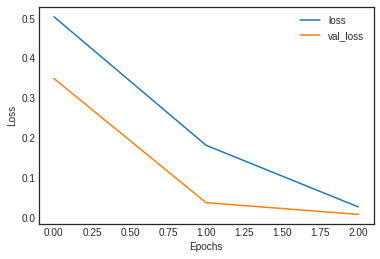

In [33]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'],'')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['loss', 'val_loss'])
plt.show()

In [34]:
input_ids = []
attention_masks = []
token_type_ids = []
test_data_labels = []

for test_sentence, test_label in tqdm(zip(test['text'], test['label']), total = len(test)):
  try:
    input_id, attention_mask, token_type_id = bert_tokenizer(test_sentence, MAX_LEN)
    input_ids.append(input_id)
    attention_masks.append(attention_mask)
    token_type_ids.append(token_type_id)
    test_data_labels.append(test_label)
  except Exception as e:
    print(e)
    pass

100%|██████████| 182/182 [00:00<00:00, 330.35it/s]


In [35]:
test_input_ids = np.array(input_ids, dtype=int)
test_attention_masks = np.array(attention_masks, dtype=int)
test_token_type_ids = np.array(token_type_ids, dtype=int)
test_inputs = (test_input_ids, test_attention_masks, test_token_type_ids)
test_data_labels = np.asarray(test_data_labels, dtype=np.int32)

In [36]:
cls_model.evaluate(test_inputs, test_data_labels, batch_size=8)

23/23 [==============================] - 34s 1s/step - loss: 0.0658 - accuracy: 0.9835


[0.06581353396177292, 0.9835164546966553]